# Sentiment Analysis app 
### Author : Evergreen Technologies 

#### This script loads pre-trained word embeddings (GloVe embeddings) into a frozen Keras Embedding layer, and uses it to train a text classification model on the 20 Newsgroup dataset  (classification of newsgroup messages into 20 different categories).

#### '''GloVe embedding data can be found at:  http://nlp.stanford.edu/data/glove.6B.zip
(source page: http://nlp.stanford.edu/projects/glove/)

#### 20 Newsgroup data can be found at:
http://www.cs.cmu.edu/afs/cs.cmu.edu/project/theo-20/www/data/news20.html


In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from keras.initializers import Constant
from matplotlib import pyplot
from keras import backend as K
import pandas as pd
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
C:\Users\hafizmrf3\Anaconda3\envs\envDL_TF1_14\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\hafizmrf3\Anaconda3\envs\envDL_TF1_14\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\hafizmrf3\Anaconda3\envs\envDL_TF1_14\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\hafiz

### Definisi Fungsi Confusion Matrix

In [2]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


### Definisi Fungsi Baca Dataset

In [3]:
def read_csv(filepath):
     if os.path.splitext(filepath)[1] != '.csv':
          return  # or whatever
     seps = [',', ';', '\t']                    # ',' is default
     encodings = [None, 'utf-8', 'ISO-8859-1']  # None is default
     for sep in seps:
         for encoding in encodings:
              try:
                  return pd.read_csv(filepath, encoding=encoding, sep=sep)
              except Exception:  # should really be more specific 
                  pass
     raise ValueError("{!r} is has no encoding in {} or seperator in {}"
                      .format(filepath, encodings, seps))

### Set lokasi Dataset dan Split Data

In [4]:
BASE_DIR = 'C:/Users/hafizmrf3/DataScienceProject/SentimentAnalysis/edx/data'
GLOVE_DIR = os.path.join(BASE_DIR, 'glovedata')
TEXT_DATA_DIR = os.path.join(BASE_DIR, 'edxdata')
COURSE_REVIEW_FILE_NAME = "spotify_labeled_edit.csv"
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

### Word Embbeding Vector

In [5]:
# first, build index mapping words in the embeddings set
# to their embedding vector

print('Indexing word vectors.')

embeddings_index = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))


Indexing word vectors.
Found 400000 word vectors.


In [6]:
# second, prepare text samples and their labels
print('Processing text dataset')

texts = []  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = []  # list of label ids

input_df = read_csv(os.path.join(TEXT_DATA_DIR, COURSE_REVIEW_FILE_NAME))

Processing text dataset


In [7]:
review_df1 = input_df[['review','label']]
review_df = review_df1[review_df1['label']!='unsup']


review_df = shuffle(review_df)
print("Here are Few Samples in data")
print(review_df.head)

print("Here total number of positive and negative samples")
print(review_df.groupby(['label']).count())

print("Converting pandas dataframe into lists")
texts = review_df['review'].values.tolist()
labels = []
labels_text = []
labels_text_unique = review_df.label.unique().tolist()
labels_text = review_df['label'].values.tolist()

idxCounter = 0
for label in labels_text_unique:
    labels_index[label] = idxCounter
    idxCounter = idxCounter + 1;

idxCounter = 0    
for label in labels_text:
    print("processing row " + str(idxCounter))
    labels.append(labels_index[label])
    idxCounter = idxCounter + 1;
    

print("Labels Array")
print(len(labels))
print("Labels Dictionary")
print(labels_index)
print("Done")

Here are Few Samples in data
<bound method NDFrame.head of                                                 review  label
606  spotify skrg gak bisa memilih lagu daftar play...      0
957         mencari lagu beberapa tidak temukankomplit      1
520  buat playlits lagu nya banyak putar shuflpayku...      1
387  sekarang jadi nggak bisa diputar sesuka hati j...      0
832  ga smua aplikasi spotify ad teks lirik nyaap h...      0
..                                                 ...    ...
512                                     lagunya random      0
49   sangat ok kwalitas suaranya hpnya mendukung at...      1
704          semua lagu nya bagus lengkap terima kasih      1
420  coba bisa ulang ulang lagunya mungkin lebih ny...      1
653  bisa mendengarkan lagu nostalgia tahun 70 80 9...      1

[1000 rows x 2 columns]>
Here total number of positive and negative samples
       review
label        
0         500
1         500
Converting pandas dataframe into lists
processing row 0
processi

In [8]:

# second, prepare text samples and their labels
#print('Processing text dataset')

#texts = []  # list of text samples
#labels_index = {}  # dictionary mapping label name to numeric id
#labels = []  # list of label ids
#for name in sorted(os.listdir(TEXT_DATA_DIR)):
#    path = os.path.join(TEXT_DATA_DIR, name)
#    if os.path.isdir(path):
#        label_id = len(labels_index)
#        labels_index[name] = label_id
#       for fname in sorted(os.listdir(path)):
#            if fname.isdigit():
#                fpath = os.path.join(path, fname)
#                args = {} if sys.version_info < (3,) else {'encoding': 'latin-1'}
#                with open(fpath, **args) as f:
#                    t = f.read()
#                    i = t.find('\n\n')  # skip header
#                    if 0 < i:
#                        t = t[i:]
#                    texts.append(t)
#                labels.append(label_id)

#print('Found %s texts.' % len(texts))


In [9]:

# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
print(indices)
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

Found 2873 unique tokens.
Shape of data tensor: (1000, 1000)
Shape of label tensor: (1000, 2)
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 2

In [10]:
print(y_val[5])

[0. 1.]


In [11]:
print('Preparing embedding matrix.')

# prepare embedding matrix
num_words = min(MAX_NUM_WORDS, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

print("done")

Preparing embedding matrix.
done


In [12]:
print('Training model.')

# train a 1D convnet with global maxpooling
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(512, 5, activation='relu')(embedded_sequences)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(512, 5, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
x = Conv1D(512, 5, activation='relu')(x)
x = Dropout(0.2)(x)
x = MaxPooling1D(5)(x)
#sesudah 0604 ditambah layer lagi
#x = Conv1D(256, 5, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = MaxPooling1D(5)(x)
#x = Conv1D(128, 5, activation='relu')(x)
#x = Dropout(0.2)(x)
#x = MaxPooling1D(5)(x)
#-----

x = Conv1D(512, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(512, activation='relu')(x)
preds = Dense(len(labels_index), activation='softmax')(x)

model = Model(sequence_input, preds)
#adam
from keras import optimizers
adam = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False) 
model.compile(loss='mean_squared_error',
              optimizer=adam,
              metrics=['acc', f1_m, precision_m, recall_m])



import time
start = time.time()

history = model.fit(x_train, y_train,
          batch_size=200,
          epochs=40,
          validation_data=(x_val, y_val))


print("Total time: ", time.time() - start, "seconds")

Training model.


Train on 800 samples, validate on 200 samples
Epoch 1/40
800/800 [==============================] - 21s 26ms/step - loss: 0.2441 - acc: 0.5337 - f1_m: 0.5322 - precision_m: 0.5331 - recall_m: 0.5312 - val_loss: 0.2414 - val_acc: 0.5300 - val_f1_m: 0.5300 - val_precision_m: 0.5300 - val_recall_m: 0.5300
Epoch 2/40
800/800 [==============================] - 21s 27ms/step - loss: 0.2368 - acc: 0.5950 - f1_m: 0.5950 - precision_m: 0.5950 - recall_m: 0.5950 - val_loss: 0.2291 - val_acc: 0.6300 - val_f1_m: 0.6300 - val_precision_m: 0.6300 - val_recall_m: 0.6300
Epoch 3/40
800/800 [==============================] - 20s 25ms/step - loss: 0.2229 - acc: 0.6275 - f1_m: 0.6275 - precision_m: 0.6275 - recall_m: 0.6275 - val_loss: 0.2173 - val_acc: 0.6900 - val_f1_m: 0.6900 - val_precision_m: 0.6900 - val_recall_m: 0.6900
Epoch 4/40
800/800 [==============================] - 20s 25ms/step - loss: 0.2027 - acc: 0.6925 - f1_m: 0.6925 - precision_m: 0.6925 - recall_m: 0.6925 - val_los

In [13]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1000, 100)         287400    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 996, 256)          128256    
_________________________________________________________________
dropout_1 (Dropout)          (None, 996, 256)          0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 199, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 195, 256)          327936    
_________________________________________________________________
dropout_2 (Dropout)          (None, 195, 256)          0   

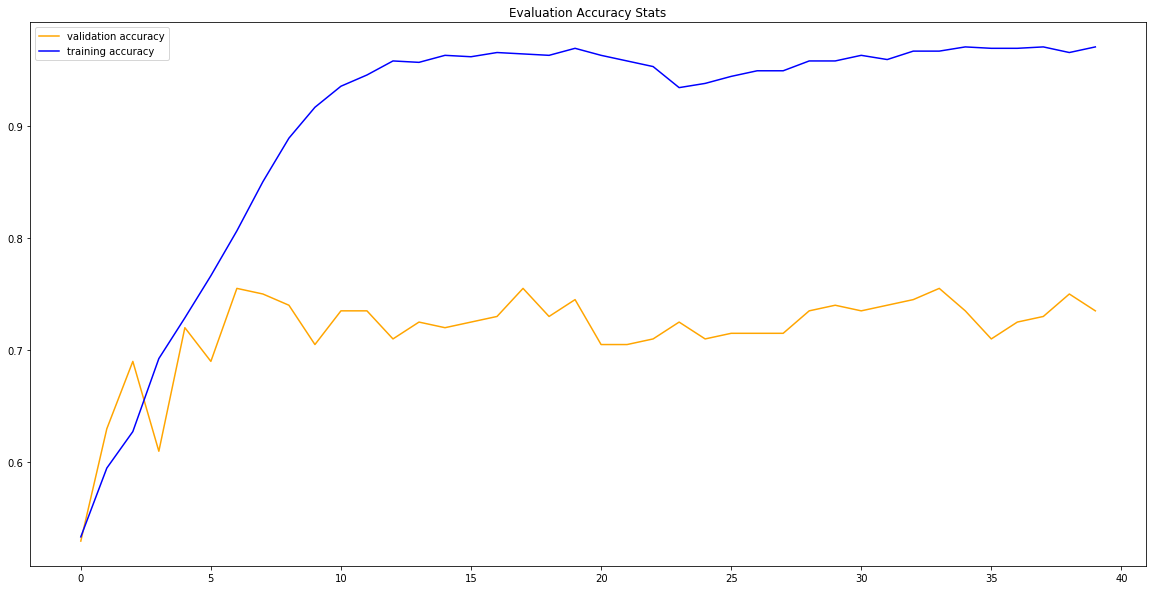

In [14]:
# plot metrics accuracy
pyplot.figure(figsize = (20, 10))
#pyplot.plot(history.history["f1_m"],  label="f1 score", color="grey")
#pyplot.plot(history.history["precision_m"], label="precision", color="black")
#pyplot.plot(history.history["recall_m"], label="recall", color="red")
pyplot.plot(history.history['val_acc'] , label="validation accuracy", color="orange")
pyplot.plot(history.history['acc'] , label="training accuracy", color="blue")
pyplot.title('Evaluation Accuracy Stats')
pyplot.legend(loc="upper left")
pyplot.show()

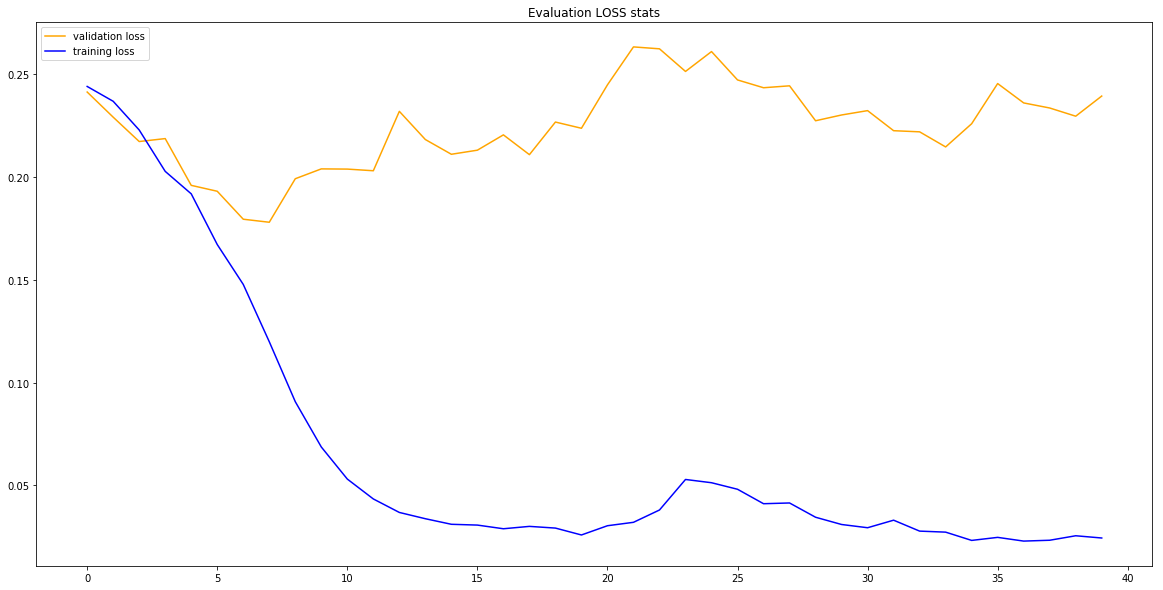

In [15]:
# plot metrics loss
pyplot.figure(figsize = (20, 10))
pyplot.plot(history.history['val_loss'] , label="validation loss", color="orange")
pyplot.plot(history.history['loss'] , label="training loss", color="blue")
pyplot.title('Evaluation LOSS stats')
pyplot.legend(loc="upper left")
pyplot.show()

In [16]:
# serialize model to JSON
model_json = model.to_json()
with open("ms3.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("ms3.h5")
print("Saved model to disk")



Saved model to disk


In [17]:
print(y_train)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


In [18]:
print(y_val)

[[0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 

In [19]:

# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))